Loading data for label Doing other things: 100%|█| 1800/1800 [00:28<00:00, 64.07
Loading data for label Pushing Two Fingers Away: 100%|█| 1800/1800 [00:27<00:00,
Loading data for label Drumming Fingers: 100%|█| 1800/1800 [00:26<00:00, 66.97it
Loading data for label Sliding Two Fingers Down: 100%|█| 1800/1800 [00:28<00:00,
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they wil

Epoch 1/10
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 495s 76ms/step - accuracy: 0.4078 - loss: 1.2599 - val_accuracy: 0.5155 - val_loss: 1.0987
Epoch 2/10
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 576s 89ms/step - accuracy: 0.4780 - loss: 1.1604 - val_accuracy: 0.5486 - val_loss: 1.0489
Epoch 3/10
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 460s 71ms/step - accuracy: 0.4974 - loss: 1.1327 - val_accuracy: 0.5549 - val_loss: 1.0382
Epoch 4/10
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 490s 76ms/step - accuracy: 0.5020 - loss: 1.1208 - val_accuracy: 0.5501 - val_loss: 1.0414
Epoch 5/10
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 465s 72ms/step - accuracy: 0.5089 - loss: 1.1089 - val_accuracy: 0.5594 - val_loss: 1.0214
Epoch 6/10
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 511s 79ms/step - accuracy: 0.5139 - loss: 1.1023 - val_accuracy: 0.5699 - val_loss: 0.9977
Epoch 7/10
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 465s 72ms/step - accuracy: 0.5162 - loss: 1.0929 - val_accuracy: 0.5728 - val_loss: 1.0026
Epoch 8/10
6480/6480 ━━━━━━━━━━━━━━━━━━━━ 465s 72ms/step - accuracy: 

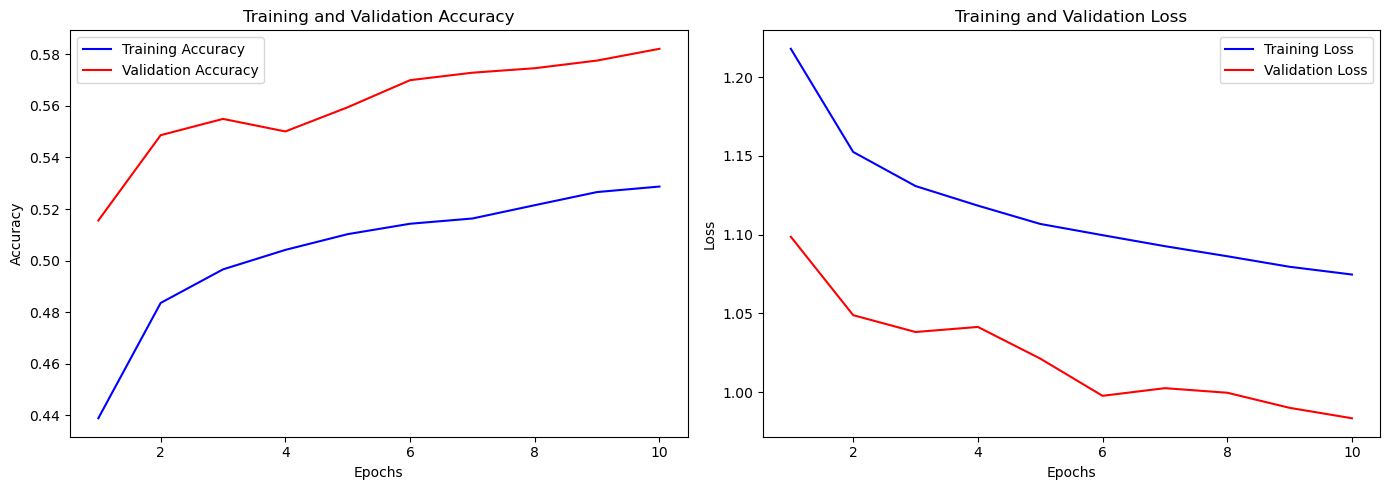

1620/1620 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step


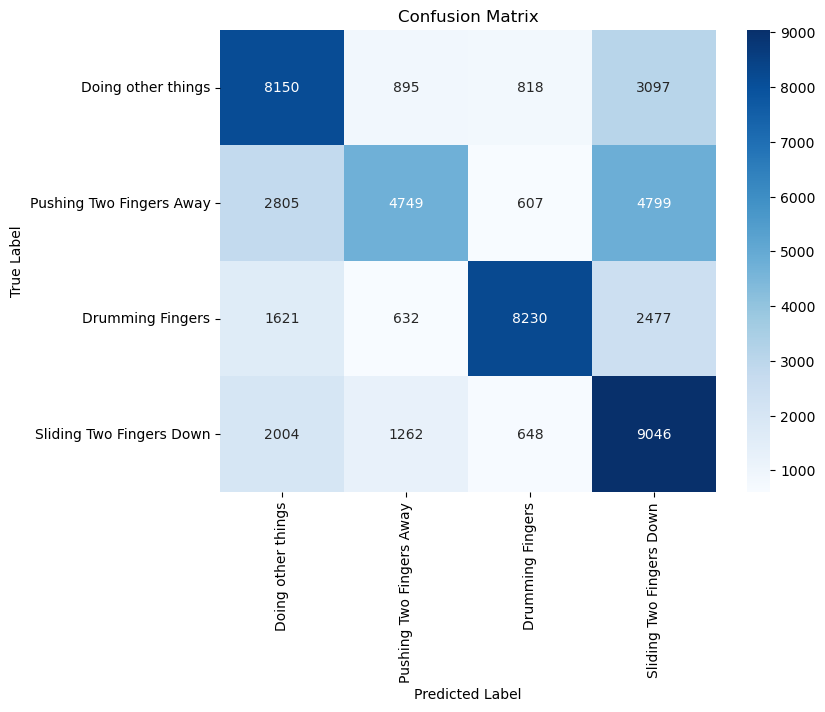

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Function to load optical flow images and labels from the output folder
def load_optical_flow_data(output_dir, metadata_file, num_labels=4, num_videos_per_label=2):
    df = pd.read_csv(metadata_file)
    unique_labels = df['label'].unique()[:num_labels]
    
    images = []
    labels = []
    label_map = {label: idx for idx, label in enumerate(unique_labels)} 
    

    for label in unique_labels:
        label_videos = df[df['label'] == label]
        
        if len(label_videos) < num_videos_per_label:
            print(f"Warning: Label {label} has less than {num_videos_per_label} videos. Using all available videos.")
            label_videos = label_videos.sample(n=len(label_videos), random_state=42)  
        else:
            label_videos = label_videos.sample(n=num_videos_per_label, random_state=42)

        for video_id in tqdm(label_videos['video_id'].unique(), desc=f"Loading data for label {label}"):
            video_dir = os.path.join(output_dir, str(video_id))  
            if not os.path.exists(video_dir):
                print(f"Video directory {video_dir} does not exist.")
                continue
            
 
            for i in range(1, 38):  
                image_path = os.path.join(video_dir, f"{video_id}_{i:05d}.png")
                if os.path.exists(image_path):
                    img = cv2.imread(image_path)
                    img = cv2.resize(img, (128, 128))  
                    images.append(img)
                    labels.append(label_map[label])
    

    images = np.array(images)
    labels = np.array(labels)
    

    images = images.astype('float32') / 255.0
    
    return images, labels, label_map, unique_labels

# Function to build the CNN model for classification
def build_cnn_model(input_shape=(128, 128, 3), num_classes=4):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # softmax for multi-class classification
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


def train_and_test_model(output_dir, metadata_file, num_labels=4, num_videos_per_label=2):
    # Load the optical flow data
    images, labels, label_map, unique_labels = load_optical_flow_data(output_dir, metadata_file, num_labels, num_videos_per_label)
    
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

    # Build the CNN model
    model = build_cnn_model()

    datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                 shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

    # Train the model and capture history
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        epochs=10,
        validation_data=(X_test, y_test)
    )

    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    
    # Plot training and validation accuracy and loss
    plot_training_progress(history)

    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plot_confusion_matrix(cm, unique_labels)

    return model


def plot_training_progress(history):
    """Plot the training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

output_dir = "/Users/yashwanthchiluka/Downloads/data"  
metadata_file = "/Users/yashwanthchiluka/Downloads/Train.csv" 

# Train and test the model
trained_model = train_and_test_model(output_dir, metadata_file, num_labels=4, num_videos_per_label=1800)
